<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# Exploratory Data Analysis

This notebook walks you through the steps to exploratory data analysis.

In [1]:
from radiant_mlhub import Collection
import tarfile
import os
from pathlib import Path
import json

import datetime
import rasterio
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

import matplotlib.pyplot as plt

### Load data

In [2]:
df = pd.DataFrame()
for value in ['df_median_1','df_median_2']:
    print('Reading Train df:', value)
    #read the pickle file
    picklefile = open(value, 'rb')
    #unpickle the dataframe
    df_tmp = pickle.load(picklefile)
    #close file
    picklefile.close()
    df = pd.concat([df,df_tmp])
    print(len(df_tmp))

Reading Train df: df_median_1
3603
Reading Train df: df_median_2
3571


In [3]:
df.reset_index(inplace=True,drop=True)
df

,field_id,20170401_B01,20170401_B02,20170401_B03,20170401_B04,20170401_B05,20170401_B06,20170401_B07,20170401_B08,20170401_B09,...,20171127_B04,20171127_B05,20171127_B06,20171127_B07,20171127_B08,20171127_B09,20171127_B11,20171127_B12,20171127_B8A,label
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.0,64.0,70.0,76.0,85.0,81.0,113.0,88.0,86.0,8
1,91.0,22.0,25.0,34.0,45.0,52.0,56.0,60.0,64.0,70.0,...,41.0,48.0,52.0,57.0,62.0,67.0,108.0,91.0,64.5,3
2,243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,38.0,63.0,72.0,76.0,83.0,86.0,64.0,79.0,4
3,286.0,13.0,16.0,23.0,30.0,37.0,44.0,49.0,53.0,57.0,...,27.0,38.0,54.0,60.0,65.0,67.0,72.0,49.0,66.0,2
4,308.0,21.0,29.0,47.0,65.0,74.0,78.0,83.0,85.0,88.0,...,67.0,78.0,81.0,86.0,92.0,90.0,122.0,93.0,94.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,18.0,25.0,41.0,64.0,77.0,82.0,90.0,98.0,103.0,...,64.0,72.0,75.0,81.0,87.0,89.0,118.0,89.0,88.0,6
7170,122532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.0,73.0,75.0,78.0,82.0,84.0,118.0,93.0,83.0,7
7171,122534.0,10.5,14.0,24.0,34.0,43.0,51.0,56.0,61.0,61.0,...,40.0,53.0,73.0,80.0,88.0,84.0,96.0,65.0,86.0,4
7172,122585.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.0,58.5,80.0,89.0,95.0,92.0,103.5,83.0,94.0,4


In [4]:
df['label'].value_counts()

4    2133
7    1220
2    1037
1     767
6     684
5     503
3     474
8     209
9     147
Name: label, dtype: int64

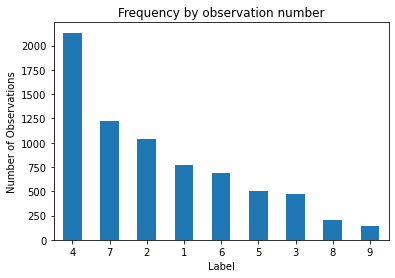

In [5]:
count_labels = pd.value_counts(df['label'], sort = True)
count_labels.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Label")
plt.ylabel("Number of Observations");

In [6]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns].head())

   20170401_B01  20170401_B02  20170401_B03  20170401_B04  20170401_B05  \
0           NaN           NaN           NaN           NaN           NaN   
1          22.0          25.0          34.0          45.0          52.0   
2           NaN           NaN           NaN           NaN           NaN   
3          13.0          16.0          23.0          30.0          37.0   
4          21.0          29.0          47.0          65.0          74.0   

   20170401_B06  20170401_B07  20170401_B08  20170401_B09  20170401_B11  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1          56.0          60.0          64.0          70.0         107.0  ...   
2           NaN           NaN           NaN           NaN           NaN  ...   
3          44.0          49.0          53.0          57.0          69.0  ...   
4          78.0          83.0          85.0          88.0         108.0  ...   

   20171122_B03  20171122_B04  20171122_B05  20171122_B06  20171122_

In [7]:
#Test
df[df['field_id']==138.0].loc[:,['20170401_B8A','20171127_B8A']]

,20170401_B8A,20171127_B8A
3607,NaN,103.0


#### Nota:
- Se observa desbalanceo en el df de los cultivos a estudiar.
- En caso de presencia de nubes (ayudado por la variable CLM) se ha reemplazado los valores originales por valor Nan en las bandas espectrales de Sentinel-2, en diferentes momentos y diferentes parcelas debido a la presencia de nubes/humo.

### Preprocesamiento - Ingeniería de Variables

#### Tratamiento nubes/humo (outlier) bandas Sentinel-2

##### Demostración Gráfica Interpolación nubes/humo (outlier)

In [8]:
cols=[]
cols += (df.filter(regex='._B8A').columns).tolist()
banda_ts = pd.DataFrame({
    'Fecha': df[cols].iloc[3607].filter(regex='.B8A').index, 
    'Banda4':df[cols].iloc[3607].filter(regex='.B8A').values
})
new = banda_ts['Fecha'].str.split("_", n = 1, expand = True) 
banda_ts['Fecha']= new[0] 

In [9]:
# Convert a datetime
banda_ts['Fecha'] = pd.to_datetime(banda_ts['Fecha'], dayfirst=True)
banda_ts.tail()

,Fecha,Banda4
33,2017-11-07,101.0
34,2017-11-12,NaN
35,2017-11-17,100.0
36,2017-11-22,NaN
37,2017-11-27,103.0


In [10]:
banda_ts = banda_ts.set_index('Fecha')

,Banda4
Fecha,
2017-04-01,NaN
2017-04-11,90.0
2017-04-21,97.0
2017-05-01,28.0
2017-05-11,NaN


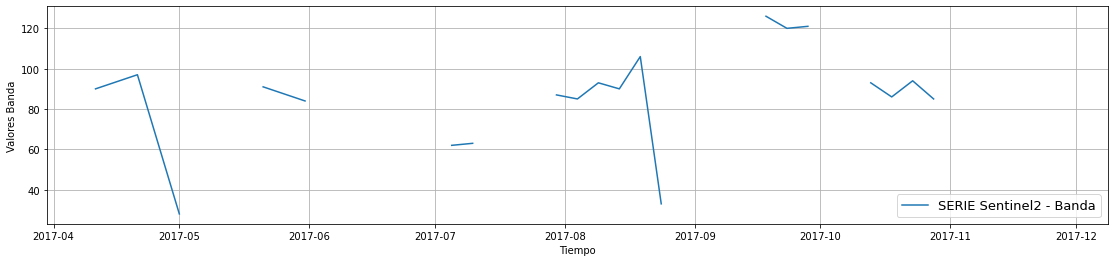

In [11]:
# Finalmente es posible plotear la serie temporal
fig, axes = plt.subplots(figsize=(19,4))
axes.plot(banda_ts.iloc[:,0], label='SERIE Sentinel2 - Banda')
axes.set_xlabel('Tiempo')
axes.set_ylabel('Valores Banda')
axes.grid(True)
axes.legend(loc='lower right', fontsize=13)
banda_ts.iloc[:,0:2].head()

In [12]:
banda_ts['Interp1'] = banda_ts['Banda4'].interpolate(method='linear',limit_direction ='backward')
banda_ts['Interp1']=banda_ts['Interp1'].interpolate(method='linear',limit_direction ='forward')
banda_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2017-04-01 to 2017-11-27
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Banda4   24 non-null     float64
 1   Interp1  38 non-null     float64
dtypes: float64(2)
memory usage: 912.0 bytes


In [13]:
dt1 =pd.DataFrame({'B4_original':banda_ts['Banda4'].values,
                                          'Interp. B4':banda_ts['Interp1'].values,
                                          }, columns=['B4_original','Interp. B4'],index=banda_ts.index)
dt1.head(10)

,B4_original,Interp. B4
Fecha,,
2017-04-01,NaN,90.0
2017-04-11,90.0,90.0
2017-04-21,97.0,97.0
2017-05-01,28.0,28.0
2017-05-11,NaN,59.5
2017-05-21,91.0,91.0
2017-05-31,84.0,84.0
2017-06-10,NaN,74.5
2017-06-20,65.0,65.0


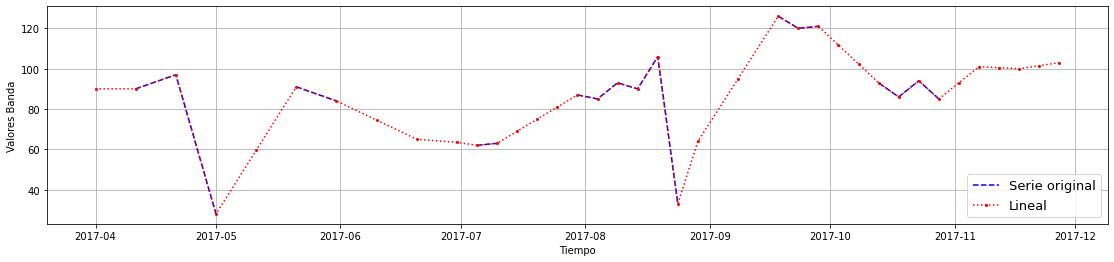

In [14]:
# Finalmente es posible plotear la serie temporal
fig, axes = plt.subplots(figsize=(19,4))
axes.plot(dt1['B4_original'], linestyle='--', ms = 4, color = 'blue', label='Serie original')
axes.plot(dt1['Interp. B4'], marker='.', ms=4, linestyle=':',color='red', label='Lineal')
axes.set_xlabel('Tiempo')
axes.set_ylabel('Valores Banda')
axes.grid(True)
axes.legend(loc='lower right', fontsize=13);

##### Aplicación al DF Interpolación nubes/humo (outlier)

In [15]:
def suavizado(col):
    cols=[]
    cols += (df.filter(regex=col).columns).tolist()
    df_banda = pd.DataFrame(columns = cols)
    df_banda_tmp = pd.DataFrame(columns = cols)
    banda = pd.DataFrame(columns = [col,'{}_I'.format(col)])
    for index, row in  df.iterrows():
        banda[col] = row.filter(regex='._{}'.format(col)).values
        #Interpolación
        banda['{}_I'.format(col)] = banda[col].interpolate(method='linear',limit_direction ='backward')
        banda['{}_I'.format(col)] =  banda['{}_I'.format(col)].interpolate(method='linear',limit_direction ='forward')
        #banda['{}_I'.format(col)] = banda[col].interpolate(method='spline',order=1,limit_direction ='backward')
        #banda['{}_I'.format(col)] =  banda['{}_I'.format(col)].interpolate(method='spline',order=1,limit_direction ='forward')
        # Dejamos los valores de la banda en una variable
        st = banda['{}_I'.format(col)].copy()
        #Suavizado de Hamunyela
        """for i in np.arange(1, (len(st)-1),1):
            st[i] = np.where(((st[i]-st[i-1] < -0.01*st[i-1]) & 
                              (st[i]-st[i+1] < -0.01*st[i+1])), 
                             (st[i-1]+st[i+1])/2, st[i])"""
        df_banda_tmp = pd.DataFrame(data = st.values.reshape(1,len(df_banda_tmp.columns)), columns = df_banda_tmp.columns)
        frames = [df_banda, df_banda_tmp]
        df_banda = pd.concat(frames)
        df_banda=df_banda.reset_index(drop=True)
    return df_banda

In [16]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11', 'B12']
df_final = df.loc[:, ['field_id','label']]
for b in bands:
    df_banda = suavizado(b)
    df_final = pd.merge(df_final, df_banda, right_index=True, left_index=True)

In [17]:
df = df_final.copy()
df

,field_id,label,20170401_B01,20170411_B01,20170421_B01,20170501_B01,20170511_B01,20170521_B01,20170531_B01,20170610_B01,...,20171013_B12,20171018_B12,20171023_B12,20171028_B12,20171102_B12,20171107_B12,20171112_B12,20171117_B12,20171122_B12,20171127_B12
0,4.0,8,28.0,28.0,20.0,17.000000,19.000000,21.0,25.0,20.50,...,54.0,40.0,56.0,56.0,65.00,74.0,80.00,86.0,87.0,88.0
1,91.0,3,22.0,21.0,22.0,20.000000,19.000000,18.0,18.0,16.00,...,81.0,71.0,79.0,79.0,82.50,86.0,92.00,88.0,89.5,91.0
2,243.0,4,1.0,1.0,1.0,1.000000,0.000000,6.0,13.5,21.00,...,69.0,17.0,68.0,62.0,69.00,68.0,68.00,69.0,66.5,64.0
3,286.0,2,13.0,12.0,11.0,11.000000,11.000000,11.0,11.0,8.50,...,46.0,34.0,22.0,44.0,45.50,47.0,48.00,49.0,49.0,49.0
4,308.0,7,21.0,16.0,19.0,16.000000,13.000000,10.0,17.0,13.00,...,51.0,36.0,57.0,60.0,61.50,63.0,65.50,68.0,80.5,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,6,18.0,13.0,16.0,14.333333,12.666667,11.0,16.0,12.50,...,62.0,52.0,68.0,68.0,70.50,73.0,74.50,76.0,82.5,89.0
7170,122532.0,7,12.0,12.0,18.0,18.000000,18.000000,18.0,18.0,14.50,...,54.0,50.0,60.0,61.0,64.00,67.0,79.00,91.0,92.0,93.0
7171,122534.0,4,10.5,11.5,11.0,44.000000,27.500000,11.0,11.0,8.25,...,66.0,35.0,67.0,62.0,62.25,62.5,63.75,65.0,37.0,65.0
7172,122585.0,4,9.0,9.0,7.0,12.000000,11.500000,11.0,16.0,11.50,...,86.5,55.0,84.0,81.0,81.50,82.0,82.00,82.0,82.5,83.0


In [18]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [19]:
#Test
df[df['field_id']==138.0].loc[:,['20170401_B8A','20171127_B8A']]

,20170401_B8A,20171127_B8A
3607,90.0,103.0


#### Cálculo Indices de vegetación

Para el cálculo de los diferentes índices de vegetación me he basado en los siguientes links:

- [Link1](https://acolita.com/lista-de-indices-espectrales-en-sentinel-2-y-landsat/)
- [Link2](https://mappinggis.com/2020/07/los-6-indices-de-vegetacion-para-completar-el-ndvi/#:~:text=Los%20%C3%8Dndices%20de%20Vegetaci%C3%B3n%20son,suelo%2C%20la%20iluminaci%C3%B3n%2C%20etc.)

- ##### Indice NDVI

In [20]:
# NDVI :(B8A-B04)/(B8A+B04)
B8A_features_col = df.filter(regex='._B8A').columns
B4_features_col = df.filter(regex='._B04').columns
NDVI = []
for i in range(38) :
    B8A = '{}'.format(B8A_features_col[i])
    B4 = '{}'.format(B4_features_col[i])
    NDVI.append('{}_NDVI'.format(B8A.split("_")[0]))
    df['{}_NDVI'.format(B8A.split("_")[0])] = (df[B8A]-df[B4])/(df[B8A]+df[B4])

- ##### Indice SLAVI

In [21]:
# SLAVI :(B8A)/(B8A+B12)
#https://www.indexdatabase.de/db/i-single.php?id=89
B12_features_col = df.filter(regex='._B12').columns
SLAVI = []
for i in range(13) :
    B8A = '{}'.format(B8A_features_col[i])
    B12 = '{}'.format(B12_features_col[i])
    SLAVI.append('{}_SLAVI'.format(B8A.split("_")[0]))
    df['{}_SLAVI'.format(B8A.split("_")[0])] = (df[B8A])/(df[B8A]+df[B12])

- ##### Indice SAVI

In [22]:
# # SAVI :1.5*(B8A-B04)/(B8A+B04+0.5)
#SAVI = []
#for i in range(13) :
#    B8A = '{}'.format(B8A_features_col[i])
#    B4 = '{}'.format(B4_features_col[i])
#    SAVI.append('{}_SAVI'.format(B8A.split("_")[0]))
#    df['{}_SAVI'.format(B8A.split("_")[0])] = (1.5*(df[B8A].divide(10000)-df[B4].divide(10000))/(df[B8A].divide(10000)+df[B4].divide(10000)+0.5)).multiply(10000)

- ##### Indice RECI

In [23]:
#RECI :(B08/B04)-1
#B8_features_col = df.filter(regex='._B08').columns
#RECI = []
#for i in range(13) :
#    B8 = '{}'.format(B8_features_col[i])
#    B4 = '{}'.format(B4_features_col[i])
#    RECI.append('{}_RECI'.format(B8.split("_")[0]))
#    df['{}_RECI'.format(B8.split("_")[0])] = (((df[B8]).divide(10000)/(df[B4]).divide(10000))-1).multiply(10000)

- ##### Indice MSI

In [24]:
# MSI :B11/B8A
B11_features_col = df.filter(regex='._B11').columns
MSI = []
for i in range(13) :
    B8A = '{}'.format(B8A_features_col[i])
    B11 = '{}'.format(B11_features_col[i])
    MSI.append('{}_MSI'.format(B8A.split("_")[0]))
    df['{}_MSI'.format(B8A.split("_")[0])] = (df[B11])/(df[B8A])

- ##### Indice NDRE

In [25]:
# NDRE :(B09-B05)/(B09+B05)
B9_features_col = df.filter(regex='._B09').columns
B5_features_col = df.filter(regex='._B05').columns
NDRE = []
for i in range(13) :
    B9 = '{}'.format(B9_features_col[i])
    B5 = '{}'.format(B5_features_col[i])
    NDRE.append('{}_NDRE'.format(B9.split("_")[0]))
    df['{}_NDRE'.format(B9.split("_")[0])] =  (df[B9]-df[B5])/(df[B9]+df[B5])

#### Cálculo Estádisticos para cada Indice espectral

Se procede a calcular ciertas medidas estadísticas por cada índice de vegetación calculado a partir del aspecto temporal de los mismos:
   - Desviación standard, 
   - Máximo, 
   - Mínimo y 
   - Media

#### Escalado Estándard:

Escalamos/Normalizamos el conjunto de datos antes de utilizarlos en los diferentes modelos. Es una buena práctica, para que los valores de las diferentes variables se encuentren en un mismo rango y de esta manera no influya una más que otra al momento de entrenar los modelos propuestos.
Este escalado, utiliza la media y la desviación típica para escalar y es bastante sensible en presencia de los outlier (humo/nubes) identificados. De todos modo ha sido el escalado que me ha dado mejor resultado por eso lo he seleccionado. En el método 3 propuesto, utilizaré técnicas para "suavizar" la presencia de nubes previamanete escalar. En el método actual obviaremos éste razonamiento.

#### Reducción Dimensionalidad
Aplicamos PCA tanto a las bandas cómo a los índices de vegetación, con la intención de obtener una variable "representativa" de la "temporalidad" de la información